# Training #

## Initialiasation ##

### Packages ###

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
torch.manual_seed(100)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 14:18:18.061312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


*Transforming DataSet to Torch*

### tensorflow to torch ###


In [2]:
# Custom dataset wrapper for PyTorch
class TFDatasetWrapper(Dataset):
    def __init__(self, tf_dataset):
        # Convert TensorFlow dataset to a list for easy use
        self.dataset = list(tf_dataset)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve an item from the dataset and convert it to PyTorch tensor
        image, label = self.dataset[idx]
        image = torch.tensor(image.numpy())  # Convert TensorFlow tensor to NumPy, then to PyTorch tensor
        label = torch.tensor(label.numpy())
        return image.permute(2, 0, 1), label  # Rearrange the dimensions to [C, H, W] for PyTorch



### loading Data ###

In [3]:
# Load the EuroSAT dataset in TensorFlow
wholedataset, info = tfds.load('eurosat/rgb', split='train[:20%]', as_supervised=True, with_info=True)

# dataset Filter the dataset to only include images with label 1
dataset = wholedataset.filter(lambda image, label: label == 1)


# Wrap the TensorFlow dataset in the PyTorch Dataset
pytorch_dataset = TFDatasetWrapper(dataset)

# Optional: Apply transformations (if necessary)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# DataLoader for iterating through the dataset
dataloader = DataLoader(pytorch_dataset, batch_size=256, shuffle=True)

# batch_size = 128
# dataloader = DataLoader(
#     MNIST('.', download=True, transform=transforms.ToTensor()),
#     batch_size=batch_size,
#     shuffle=True)

### tensor to image ###

In [4]:

def tensor_to_images(image_tensor, num_images=12, size=(3, 64, 64)):
    # Check if the image tensor contains enough data to reshape
    expected_elements = num_images * size[0] * size[1] * size[2]
    if image_tensor.numel() < expected_elements:
        print("sad")

    try:
        # Reshape and create a grid
        image_unflat = image_tensor.detach().cpu().view(-1, *size)
        image_grid = make_grid(image_unflat[:num_images], nrow=6)

        # Permute the dimensions for displaying and handle the color channels correctly
        if image_grid.size(0) == 1:
            # Handle grayscale images that might be squeezed out
            plt.imshow(image_grid.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        else:
            plt.imshow(image_grid.permute(1, 2, 0).numpy())
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")


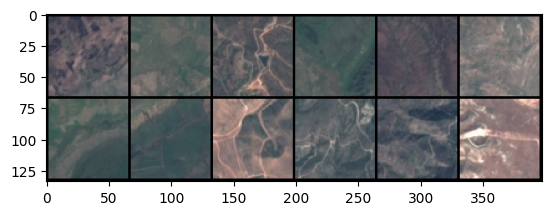

In [5]:
sample_images, sample_labels = next(iter(dataloader))
tensor_to_images(sample_images)

### Device Config ###

In [6]:
## Device configuration

# Check for GPU availability with CUDA
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU found")
# Check for Apple MPS availability
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS GPU found")
else: 
    print("ERROR: No GPU or MPS device found.")
    device = torch.device('cpu')  # Fallback to CPU
print(device)

MPS GPU found
mps


### Generator Class ###

In [7]:
# class Generator(nn.Module):
#     def __init__(self, noise_dimension=100,
#                        image_channels=3, image_size=64,
#                        hidden_dimension=128):
#         super(Generator, self).__init__()

#         self.n_dim = noise_dimension
#         self.im_channels = image_channels
#         self.im_size = image_size
#         self.im_dim = image_channels * image_size * image_size  # 3 * 64 * 64 = 12288
#         self.h_dim = hidden_dimension

#         # Generator network
#         self.gen = nn.Sequential(
#             self.generator_block(self.n_dim, self.h_dim * 2),  # Expanding the noise dimension
#             self.generator_block(self.h_dim * 2, self.h_dim * 4),
#             self.generator_block(self.h_dim * 4, self.h_dim * 8),
#             self.generator_block(self.h_dim * 8, self.h_dim * 16),
#             nn.Linear(self.h_dim * 16, self.im_dim),  # Final output to match image dimension
#             nn.Sigmoid()  # Ensuring output is between [0,1]
#         )

#     def forward(self, noise):
#         image = self.gen(noise)
#         return image.view(-1, self.im_channels, self.im_size, self.im_size)
#         # Reshapes output to (batch_size, channels, height, width)

#     # Simple neural network single block
#     def generator_block(self, in_dimension, out_dimension):
#         return nn.Sequential(
#             nn.Linear(in_dimension, out_dimension),
#             nn.BatchNorm1d(out_dimension),
#             nn.ReLU(inplace=True),
#         )

## Introducing convulutional layers
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dimension=100,
                       image_channels=3, image_size=64,
                       hidden_dimension=128):
        super(Generator, self).__init__()

        self.n_dim = noise_dimension
        self.im_channels = image_channels
        self.im_size = image_size
        self.h_dim = hidden_dimension

        # Project and reshape the input noise to a smaller spatial dimension
        self.init_size = image_size // 16  # Divide the image size by 16
        self.l1 = nn.Sequential(
            nn.Linear(self.n_dim, self.h_dim * 8 * self.init_size * self.init_size)
        )

        # Generator network with an additional upsampling step
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(self.h_dim * 8),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim * 8, self.h_dim * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.h_dim * 4),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim * 4, self.h_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.h_dim * 2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim * 2, self.h_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.h_dim),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # Additional upsampling step to reach 64x64
            nn.Conv2d(self.h_dim, image_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Using Tanh for final layer to output values between -1 and 1
        )

    def forward(self, noise):
        # Transform noise to suitable size
        out = self.l1(noise)
        out = out.view(-1, self.h_dim * 8, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img  # Output is already of size (batch_size, channels, height, width), no need to reshape



In [8]:
def get_noise(n_samples, noise_vector_dimension, device=None):
    return torch.randn(n_samples, noise_vector_dimension, device = 'mps')
print(device)

mps


### Dicriminator ###

In [9]:
# #try 2
# class Discriminator(nn.Module):
#     def __init__(self,
#                  image_channels=3, image_size=64,
#                  hidden_dimension=128):
#         super(Discriminator, self).__init__()

#         # Calculate image dimensions from channels and size
#         self.im_dim = image_channels * image_size * image_size  # 3 * 64 * 64 = 12,288
#         self.h_dim = hidden_dimension

#         # Discriminator network
#         self.disc = nn.Sequential(
#             self.discriminator_block(self.im_dim, self.h_dim * 8),  # First layer to handle large input dimension
#             self.discriminator_block(self.h_dim * 8, self.h_dim * 4),
#             self.discriminator_block(self.h_dim * 4, self.h_dim * 2),
#             self.discriminator_block(self.h_dim * 2, self.h_dim),
#             nn.Linear(self.h_dim, 1),  # Output a single value for binary classification
#             nn.Sigmoid()  # Sigmoid activation to output a probability
#         )

#     def forward(self, image):
#         # Flatten image
#         image = image.view(image.size(0), -1)  # Flatten the image to a vector for the linear layer
#         return self.disc(image)

#     def discriminator_block(self, in_dimension, out_dimension):
#         return nn.Sequential(
#             nn.Linear(in_dimension, out_dimension),
#             nn.BatchNorm1d(out_dimension),  # Added batch normalization
#             nn.LeakyReLU(0.2, inplace=True)  # Use leaky ReLU to allow a small gradient when the unit is not active
#         )

## approach introducing convolutional layers
# class Discriminator(nn.Module):
#     def __init__(self, image_channels=3, image_size=64, hidden_dimension=128):
#         super(Discriminator, self).__init__()

#         self.fc_input_dim = image_channels * (image_size // 16) * (image_size // 16) * hidden_dimension

#         # Example of a preceding convolutional layer that might exist
#         self.features = nn.Sequential(
#             nn.Conv2d(image_channels, hidden_dimension, 4, 2, 1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(hidden_dimension, hidden_dimension * 2, 4, 2, 1),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Add more layers as needed
#             nn.Flatten()
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(self.fc_input_dim, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, image):
#         features = self.features(image)
#         classification = self.classifier(features)
#         return classification
    
class Discriminator(nn.Module):
    def __init__(self, image_channels=3, image_size=64, hidden_dimension=128):
        super(Discriminator, self).__init__()

        output_dim = image_size // 4  # Adjust based on actual convolution layers and their stride/padding
        self.fc_input_dim = hidden_dimension * 2 * (output_dim ** 2)

        self.features = nn.Sequential(
            nn.Conv2d(image_channels, hidden_dimension, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dimension, hidden_dimension * 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        features = self.features(image)
        classification = self.classifier(features)
        return classification



In [10]:
# Hyperparameters for training loop
n_epochs = 500
noise_dimension = 200
lr = 0.0005
display_step = 25

# criterion = nn.BCEWithLogitsLoss()

# criterion.to(device)
print(device)

mps


In [11]:
# # Generator & Optimizer for Generator
# gen = Generator(noise_dimension).to(device)
# gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# # Discriminator & Optimizer for Discriminator
# disc = Discriminator().to(device)
# disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [12]:
# Generator & Optimizer for Generator
gen = Generator(noise_dimension=noise_dimension).to(device)  # Assume Generator expects a noise_dimension parameter
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

# Discriminator & Optimizer for Discriminator
disc = Discriminator(image_channels=3, image_size=64).to(device)  # Assume Discriminator expects image properties
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

### loss ###

In [13]:
# def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
#     # Generate noise and pass to generator
#     fake_noise = get_noise(num_images, noise_dimension, device=device)
#     fake = gen(fake_noise)

#     # Pass fake features to discriminator
#     # All of them will got label as 0
#     # .detach() here is to ensure that only discriminator parameters will get update
#     disc_fake_pred = disc(fake.detach())
#     disc_fake_loss = criterion(disc_fake_pred,
#                                torch.zeros_like(disc_fake_pred))

#     # Pass real features to discriminator
#     # All of them will got label as 1
#     #real = real.view(-1, 3, 64, 64)
#     real = real.float() /255
#     disc_real_pred = disc(real)
#     disc_real_loss = criterion(disc_real_pred,
#                                torch.ones_like(disc_real_pred))

#     # Average of loss from both real and fake features
#     disc_loss = (disc_fake_loss + disc_real_loss) / 2
#     return disc_loss

# def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
#     # Generate noise and pass to generator
#     fake_noise = get_noise(num_images, noise_dimension, device=device)
#     fake = gen(fake_noise)

#     # Pass fake features to discriminator
#     # But all of them will got label as 1
#     disc_fake_pred = disc(fake)
#     gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
#     return gen_loss

In [14]:
# ## DICRIMINATOR LOSS
# def gradient_penalty(disc, real, fake, device='mps'):
#     batch_size, C, H, W = real.shape
#     epsilon = torch.rand((batch_size, 1, 1, 1), device='mps')
#     interpolated_images = real * epsilon + fake * (1 - epsilon)
#     interpolated_images.requires_grad_(True)
    
#     mixed_scores = disc(interpolated_images)
#     gradient = torch.autograd.grad(
#         inputs=interpolated_images,
#         outputs=mixed_scores,
#         grad_outputs=torch.ones_like(mixed_scores),
#         create_graph=True,
#         retain_graph=True,
#     )[0]
#     gradient = gradient.view(gradient.shape[0], -1)
#     gradient_norm = gradient.norm(2, dim=1)
#     penalty = ((gradient_norm - 1) ** 2).mean()
#     return penalty

# def get_disc_loss(gen, disc, real, num_images, noise_dimension, device='mps'):
#     fake_noise = get_noise(num_images, noise_dimension, device='mps')
#     fake = gen(fake_noise)

#     disc_fake_pred = disc(fake.detach())
#     disc_real_pred = disc(real)

#     disc_loss = -(torch.mean(disc_real_pred) - torch.mean(disc_fake_pred))
#     gp = gradient_penalty(disc, real, fake, device=device)
#     disc_loss += 10 * gp  # lambda for gradient penalty commonly set to 10

#     return disc_loss

# ## GENERATOR LOSS
# def get_gen_loss(gen, disc, num_images, noise_dimension, device='mps'):
#     fake_noise = get_noise(num_images, noise_dimension, device=device)
#     fake = gen(fake_noise)
#     disc_fake_pred = disc(fake)
    
#     # Minimax Loss
#     gen_loss = torch.mean(torch.nn.functional.softplus(-disc_fake_pred))  # log(1 + exp(-x))
#     return gen_loss
## Discriminator Loss
def gradient_penalty(disc, real, fake, device='mps'):
    batch_size, C, H, W = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1), device=device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    interpolated_images.requires_grad_(True)
    
    mixed_scores = disc(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores, device=device),  # Ensure device consistency
        create_graph=True,
        retain_graph=True
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

def get_disc_loss(gen, disc, real, num_images, noise_dimension, device='mps'):
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    disc_fake_pred = disc(fake.detach())  # Detach to stop gradients from flowing into the generator
    disc_real_pred = disc(real)

    disc_loss = -(torch.mean(disc_real_pred) - torch.mean(disc_fake_pred))  # WGAN loss
    gp = gradient_penalty(disc, real, fake, device=device)
    disc_loss += 10 * gp  # Lambda for gradient penalty commonly set to 10

    return disc_loss

## Generator Loss
def get_gen_loss(gen, disc, num_images, noise_dimension, device='mps'):
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    
    # Non-saturating GAN loss
    gen_loss = torch.mean(torch.nn.functional.softplus(-disc_fake_pred))
    return gen_loss

def get_noise(num_images, noise_dimension, device='mps'):
    return torch.randn(num_images, noise_dimension, device=device)

### training ###

In [15]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

gen.to(device)
disc.to(device)

# Array for saving gen_loss and disc_loss
gen_loss_array = []
disc_loss_array = []

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        #print(real.size())
        #print(real.shape)

        real = real.float() / 255
        real = real.float().to(device)

        #print(real.size())
        #print(real.shape)

        cur_batch_size = len(real)
  
        # Training generator
        gen_opt.zero_grad() # Clears the gradients of the generator's parameters.
        gen_loss = get_gen_loss(gen, disc, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        # Training discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True) # true if multiple backward passes are done for the same network in one iteration.
        disc_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, noise_dimension, device='mps')
            fake = gen(fake_noise)
            tensor_to_images(fake)
            tensor_to_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            gen_loss_array.append(mean_generator_loss)
            disc_loss_array.append(mean_discriminator_loss)

        # if (cur_step % 100 == 0) and (cur_step > 0):
        #     plt.plot(gen_loss_array, label='Generator Loss')
        #     plt.plot(disc_loss_array, label='Discriminator Loss')
        #     plt.legend()
        #     plt.show()

        cur_step += 1


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:24<00:49, 24.85s/it]


KeyboardInterrupt: 